# Image Segmentation on Camvid Dataset.

## Specifications : 
- Dataset used : https://storage.googleapis.com/laurencemoroney-blog.appspot.com/
- Encoder used : Using a pretrained VGG-16 network.
- Decoder used : FCN-8 network for upsampling and generating the predictions.
- The output will be a label map (i.e. segmentation mask) with predictions for 12 classes

# 1. Importing all the Libraries

In [1]:
import os
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
# for using tensorflow-cpu, as i have Nvidia 940MX(2gb), which results in OOM, resource exhaustion problem. 
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import tensorflow as tf 
import matplotlib.pyplot as plt 
import seaborn as sns 
from PIL import Image, ImageFont, ImageDraw
print(f'Tensorflow version : {tf.__version__}')

Tensorflow version : 2.5.0


# 2. Dataset Preparation.

## Download the dataset. 
As I already have downloaded and extratected the dataset to the following path. 

path = "C:\Users\User\NerdStuff\1.DS\6.Tensorflow-Advanced\C3\Datasets\fcnn-dataset"

The dataset downloaded contains folders for images and annotations. 
- The *images* contain the video frames 
- The *annotations* contain the pixel-wise label maps. 
- Each label map has the shape `(height, width , 1)` with each point in this space denoting the corresponding pixel's class. 
- Classes are in the range `[0, 11]` (i.e. 12 classes)  the pixel labels correspond to these classes.

| Value  | Class Name    |
| -------| -------------| 
| 0      | sky |
| 1      | building      |
| 2      | column/pole      |
| 3      | road |
| 4      | side walk     |
| 5      | vegetation      |
| 6      | traffic light |
| 7      | fence      |
| 8      | vehicle     |
| 9      | pedestrian |
| 10      | byciclist      |
| 11      | void      |

For example, if a pixel is part of a road, then that point will be labeled `3` in the label map. Run the cell below to create a list containing the class names:



In [2]:
# pixel labels in the video frames
class_names = ['sky', 'building','column/pole', 'road', 'side walk', 'vegetation', 'traffic light', 'fence', 'vehicle', 'pedestrian', 'byciclist', 'void']

## Helper function 1 :  to get the paths of images and label maps from respective directories. 

In [3]:
def get_dataset_slice_paths(image_dir, label_map_dir):
    
    # first getting all the image file names 
    # then adding the image directory to those files to make the complete path.
    image_name_list = os.listdir(image_dir)
    label_map_name_list = os.listdir(label_map_dir)

    image_paths = [os.path.join(image_dir, image_name) for image_name in image_name_list]
    label_map_paths = [os.path.join(label_map_dir,label_map_name) for label_map_name in label_map_name_list]
    return image_paths, label_map_paths

## Helper function 2 : Mapping Function. 
- This function reads annotations and images from filename.
- Resizes and reshapes them .
- Normalizes them .

## `Notes:`
- tf.cast :  Casts a tensor to a new type.
- tf.equal : Returns the truth value of (x == y) element-wise.
- tf.stack : Stacks a list of rank-R tensors into one rank-(R+1) tensor.

In [4]:
def map_fname_to_image_and_labelmap(image_fname, labelmap_fname, height=224, width=224):
    # Converting images to tensors, Resizing, reshaping & Normalizing them.
    image_raw = tf.io.read_file(image_fname)
    image = tf.image.decode_jpeg(image_raw)
    image = tf.image.resize(image, (height, width,))
    image = tf.reshape(image, (height, width, 3,))
    image = image/127.5
    image -= 1

    # Converting label_maps to tensors, Resizing and reshaping them.
    label_map_raw = tf.io.read_file(labelmap_fname)
    label_map = tf.image.decode_jpeg(label_map_raw)
    label_map = tf.image.resize(label_map, (height, width,))
    label_map = tf.cast(label_map, dtype=tf.int32)
    label_map = tf.reshape(label_map, (height, width, 1))
    # reshaping the label maps from (height, width, 1) to (height, width, 12)
    stack_list = []
    for c in range(len(class_names)):
        # checking if annotation is equal to the class name, 
        # if equal casts into tf.int32, appends to the stack list, 
        # then stacks them to complete the annotation 
        mask = tf.equal(label_map[:,:,0], tf.constant(c))  
        stack_list.append(tf.cast(mask, dtype=tf.int32))

    label_map = tf.stack(stack_list, axis=2)

    return image, label_map 

## Helper function 3,4 : Getting Training and testing dataset.
`Note : `
- tf.data.Dataset.from_tensor_slices() : uses tensors to build a dataset.
- tf.data.Dataset.repeat : Repeats this dataset so each original value is seen count times.
- tf.data.Dataset.prefetch : Most dataset input pipelines should end with a call to prefetch. This allows later elements to be prepared while the current element is being processed. This often improves latency and throughput, at the cost of using additional memory to store prefetched elements.

In [5]:
batch_size = 64
def get_train_dataset(image_paths, label_map_paths):
    train_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_map_paths))
    train_dataset = train_dataset.map(map_fname_to_image_and_labelmap)
    train_dataset = train_dataset.shuffle(100, reshuffle_each_iteration=True)
    train_dataset = train_dataset.batch(batch_size)
    train_dataset = train_dataset.repeat()
    train_dataset = train_dataset.prefetch(-1)
    return train_dataset

def get_validation_dataset(image_paths, label_map_paths):
    validation_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_map_paths))
    validation_dataset = validation_dataset.map(map_fname_to_image_and_labelmap)
    validation_dataset = validation_dataset.batch(batch_size)
    validation_dataset = validation_dataset.repeat()
    return validation_dataset

## Generate Train and Validation Dataset from a given Dataset directory.

In [6]:
dataset_path = r"C:\Users\User\NerdStuff\1.DS\6.Tensorflow-Advanced\C3\Datasets\fcnn-dataset"
folders = os.listdir(dataset_path)
print(folders)

['annotations_prepped_test', 'annotations_prepped_train', 'images_prepped_test', 'images_prepped_train']


In [7]:
# Getting the directory name
train_image_dir = f'{dataset_path}\{folders[3]}'
train_labelmap_dir = f'{dataset_path}\{folders[1]}'
validation_image_dir = f'{dataset_path}\{folders[2]}'
validation_labelmap_dir = f'{dataset_path}\{folders[0]}'
validation_labelmap_dir

'C:\\Users\\User\\NerdStuff\\1.DS\\6.Tensorflow-Advanced\\C3\\Datasets\\fcnn-dataset\\annotations_prepped_test'

In [8]:
# get the paths to the images
train_image_paths, train_label_map_paths = get_dataset_slice_paths(train_image_dir, train_labelmap_dir)
validation_image_paths, validation_label_map_paths = get_dataset_slice_paths(validation_image_dir, validation_labelmap_dir)

# generate the Train and Validation Dataset.
train_dataset = get_train_dataset(train_image_paths, train_label_map_paths)
validation_dataset = get_validation_dataset(validation_image_paths, validation_label_map_paths)

# Visualizing the dataset.

In [9]:
# generate a list that contains one color for each class
colors = sns.color_palette(None, len(class_names))


for class_name, color in zip(class_names, colors):
  print(f'{class_name} -- {color}')

sky -- (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
building -- (1.0, 0.4980392156862745, 0.054901960784313725)
column/pole -- (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
road -- (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
side walk -- (0.5803921568627451, 0.403921568627451, 0.7411764705882353)
vegetation -- (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)
traffic light -- (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)
fence -- (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)
vehicle -- (0.7372549019607844, 0.7411764705882353, 0.13333333333333333)
pedestrian -- (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)
byciclist -- (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
void -- (1.0, 0.4980392156862745, 0.054901960784313725)


# This Following utility Code is taken from Lawrence's TF Advanced Techniques Course .

In [10]:
# Visualization Utilities

def fuse_with_pil(images):
  '''
  Creates a blank image and pastes input images

  Args:
    images (list of numpy arrays) - numpy array representations of the images to paste
  
  Returns:
    PIL Image object containing the images
  '''

  widths = (image.shape[1] for image in images)
  heights = (image.shape[0] for image in images)
  total_width = sum(widths)
  max_height = max(heights)

  new_im = PIL.Image.new('RGB', (total_width, max_height))

  x_offset = 0
  for im in images:
    pil_image = PIL.Image.fromarray(np.uint8(im))
    new_im.paste(pil_image, (x_offset,0))
    x_offset += im.shape[1]
  
  return new_im


def give_color_to_annotation(annotation):
  '''
  Converts a 2-D annotation to a numpy array with shape (height, width, 3) where
  the third axis represents the color channel. The label values are multiplied by
  255 and placed in this axis to give color to the annotation

  Args:
    annotation (numpy array) - label map array
  
  Returns:
    the annotation array with an additional color channel/axis
  '''
  seg_img = np.zeros( (annotation.shape[0],annotation.shape[1], 3) ).astype('float')
  
  for c in range(12):
    segc = (annotation == c)
    seg_img[:,:,0] += segc*( colors[c][0] * 255.0)
    seg_img[:,:,1] += segc*( colors[c][1] * 255.0)
    seg_img[:,:,2] += segc*( colors[c][2] * 255.0)
  
  return seg_img


def show_predictions(image, labelmaps, titles, iou_list, dice_score_list):
  '''
  Displays the images with the ground truth and predicted label maps

  Args:
    image (numpy array) -- the input image
    labelmaps (list of arrays) -- contains the predicted and ground truth label maps
    titles (list of strings) -- display headings for the images to be displayed
    iou_list (list of floats) -- the IOU values for each class
    dice_score_list (list of floats) -- the Dice Score for each vlass
  '''

  true_img = give_color_to_annotation(labelmaps[1])
  pred_img = give_color_to_annotation(labelmaps[0])

  image = image + 1
  image = image * 127.5
  images = np.uint8([image, pred_img, true_img])

  metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0]
  metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place
  
  display_string_list = ["{}: IOU: {} Dice Score: {}".format(class_names[idx], iou, dice_score) for idx, iou, dice_score in metrics_by_id]
  display_string = "\n\n".join(display_string_list) 

  plt.figure(figsize=(15, 4))

  for idx, im in enumerate(images):
    plt.subplot(1, 3, idx+1)
    if idx == 1:
      plt.xlabel(display_string)
    plt.xticks([])
    plt.yticks([])
    plt.title(titles[idx], fontsize=12)
    plt.imshow(im)


def show_annotation_and_image(image, annotation):
  '''
  Displays the image and its annotation side by side

  Args:
    image (numpy array) -- the input image
    annotation (numpy array) -- the label map
  '''
  new_ann = np.argmax(annotation, axis=2)
  seg_img = give_color_to_annotation(new_ann)
  
  image = image + 1
  image = image * 127.5
  image = np.uint8(image)
  images = [image, seg_img]
  
  images = [image, seg_img]
  fused_img = fuse_with_pil(images)
  plt.imshow(fused_img)


def list_show_annotation(dataset):
  '''
  Displays images and its annotations side by side

  Args:
    dataset (tf Dataset) - batch of images and annotations
  '''

  ds = dataset.unbatch()
  ds = ds.shuffle(buffer_size=100)

  plt.figure(figsize=(25, 15))
  plt.title("Images And Annotations")
  plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.05)

  # we set the number of image-annotation pairs to 9
  # feel free to make this a function parameter if you want
  for idx, (image, annotation) in enumerate(ds.take(9)):
    plt.subplot(3, 3, idx + 1)
    plt.yticks([])
    plt.xticks([])
    show_annotation_and_image(image.numpy(), annotation.numpy())

 

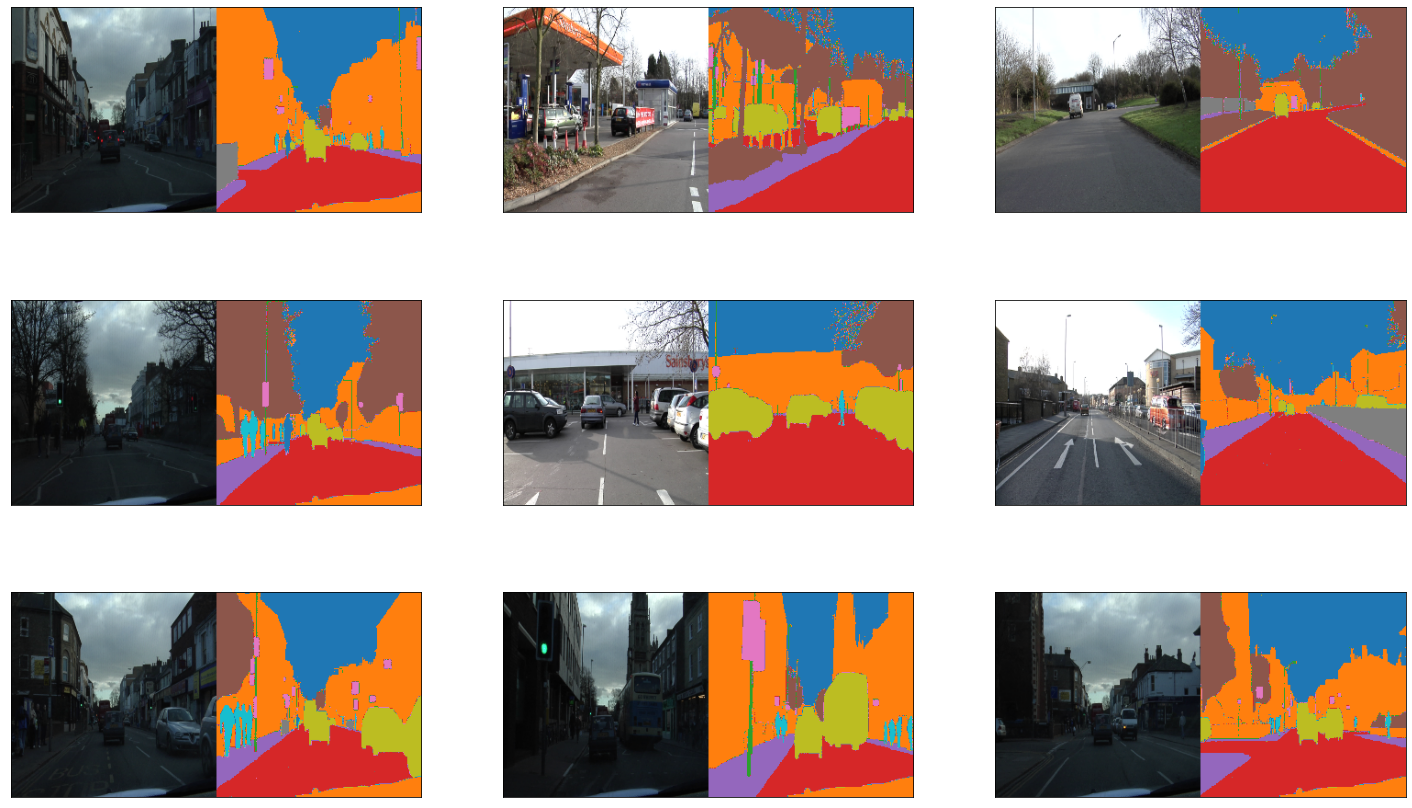

In [11]:
list_show_annotation(train_dataset)

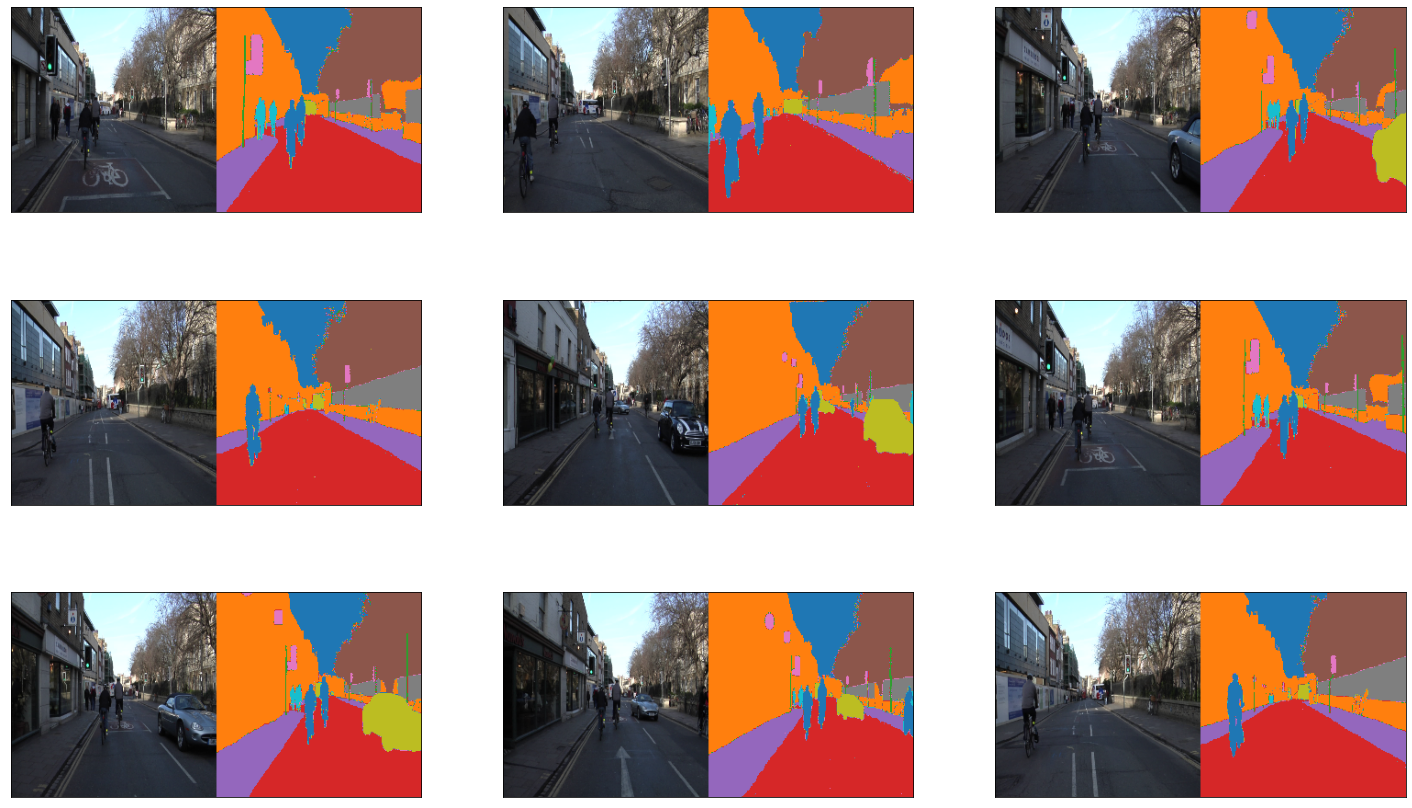

In [12]:
list_show_annotation(validation_dataset) 

# Defining the Model.
As we have processed the dataset , we will now build the Image Segmentation Model. 
Image Segmentation Model consists of 2 parts :
- Encoder : We will be using VGG-16 Network Architecture(Without the dense blocks) for Enocoding. It extracts features from the images.
- Decoder : We will be using FCN-8 Network to decode the extracted features and upsample them to get back the normal segmanted image.

## Encoder Part. 

<img src='https://media.geeksforgeeks.org/wp-content/uploads/20200219152327/conv-layers-vgg16.jpg'>

### Pretrained VGG weight download.

In [13]:
vgg_weight_link = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
vgg_weights_path = "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

### Defining the Convolutional Block

In [14]:
def conv_block(x, n_convs, filters, kernel_size, activation, pool_size, pool_stride, block_name):
    for i in range(n_convs):
        x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding='same', name=f'{block_name}_conv{i}')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=pool_size, strides=pool_size, name=f'{block_name}_pool{i}')(x)
    return x

### Defining the VGG-16 Network.

In [15]:
def VGG_16(image_input):

    # convolutional Blocks
    x = conv_block(image_input, n_convs=2, filters=64, kernel_size=(3,3), activation='relu', pool_size=(2,2), pool_stride=(2,2), block_name='block1')
    p1 = x
    x = conv_block(x, n_convs=2, filters=128, kernel_size=(3,3), activation='relu', pool_size=(2,2), pool_stride=(2,2), block_name='block2')
    p2 = x
    x = conv_block(x, n_convs=3, filters=256, kernel_size=(3,3), activation='relu', pool_size=(2,2), pool_stride=(2,2), block_name='block3')
    p3 = x
    x = conv_block(x, n_convs=3, filters=512, kernel_size=(3,3), activation='relu', pool_size=(2,2), pool_stride=(2,2), block_name='block4')
    p4 = x
    x = conv_block(x, n_convs=3, filters=512, kernel_size=(3,3), activation='relu', pool_size=(2,2), pool_stride=(2,2), block_name='block5')
    p5 = x

    vgg = tf.keras.Model(image_input, p5)
    vgg.load_weights(vgg_weights_path)
    # n = 4096
    # c6 = tf.keras.layers.Conv2D( n , ( 7 , 7 ) , activation='relu' , padding='same', name="conv6")(p5)
    # c7 = tf.keras.layers.Conv2D( n , ( 1 , 1 ) , activation='relu' , padding='same', name="conv7")(c6)
    
    return (p1, p2, p3, p4, p5)

## Decoder Part. 

<img src='https://drive.google.com/uc?export=view&id=1lrqB4YegV8jXWNfyYAaeuFlwXIc54aRP' alt='fcn-8'>

## Defining the FCN-8 Network.

In [16]:
def FCN_8(convs, n_classes):
    f1, f2, f3, f4, f5 = convs 
    # block 1
     # upsample the output of the encoder then crop extra pixels that were introduced
    o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(4,4), strides=(2,2), use_bias=False)(f5)
    o = tf.keras.layers.Cropping2D(cropping=(1,1))(o)
    # load the pool 4 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
    o2 = f4
    o2 = tf.keras.layers.Conv2D(n_classes, kernel_size=(1,1), activation='relu', padding='same')(o2)
    # add the results of the upsampling and pool 4 prediction
    o = tf.keras.layers.Add()([o, o2])
    # upsample the resulting tensor of the operation 'o'
    o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(4,4), strides=(2,2), use_bias=True)(o)
    o = tf.keras.layers.Cropping2D(cropping=(1,1))(o)

    # block 2
    # load the pool 3 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
    o3 = f3
    o3 = tf.keras.layers.Conv2D(n_classes, kernel_size=(1,1), activation='relu', padding='same')(o3)
    # add the results of the upsampling and pool 3 prediction
    o = tf.keras.layers.Add()([o, o3])
    # upsample up to the size of the original image
    o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(8,8), strides=(8,8), use_bias=False)(o3)
    # append a softmax to get the class probabilities
    o = (tf.keras.layers.Activation('softmax'))(o)
    return o


## Define Final Model

In [17]:
def segmentation_model():
    inputs = tf.keras.layers.Input(shape=(224,224,3,))
    convs = VGG_16(image_input=inputs)
    outputs = FCN_8(convs, 12)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

In [18]:
model = segmentation_model() 
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool1 (MaxPooling2D)  (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv0 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool1 (MaxPooling2D)  (None, 56, 56, 128)       0   

## Compiling the model.

In [19]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=1E-2, momentum=0.9, nesterov=True),
    loss='categorical_crossentropy',
    metrics=['accuracy'] 
    )

## Training the Model.

In [20]:
train_images_num = 367 
validation_image_num = 101 
epochs = 200

steps_per_epoch = train_images_num // batch_size
validation_steps_per_epoch = validation_image_num // batch_size

history = model.fit(
    train_dataset, steps_per_epoch=steps_per_epoch, epochs=epochs, 
    validation_data=validation_dataset, validation_steps=validation_steps_per_epoch)

=======] - 226s 46s/step - loss: 1.5865 - accuracy: 0.3652 - val_loss: 1.7426 - val_accuracy: 0.3610
Epoch 26/200
5/5 [==============================] - 215s 46s/step - loss: 1.5821 - accuracy: 0.3803 - val_loss: 1.7834 - val_accuracy: 0.3637
Epoch 27/200
5/5 [==============================] - 214s 43s/step - loss: 1.6301 - accuracy: 0.3908 - val_loss: 1.7029 - val_accuracy: 0.3814
Epoch 28/200
5/5 [==============================] - 216s 43s/step - loss: 1.5208 - accuracy: 0.4368 - val_loss: 1.7231 - val_accuracy: 0.4490
Epoch 29/200
5/5 [==============================] - 215s 43s/step - loss: 1.4721 - accuracy: 0.4872 - val_loss: 1.7007 - val_accuracy: 0.4839
Epoch 30/200
5/5 [==============================] - 215s 44s/step - loss: 1.3980 - accuracy: 0.5246 - val_loss: 1.5889 - val_accuracy: 0.5154
Epoch 31/200
5/5 [==============================] - 224s 46s/step - loss: 1.4002 - accuracy: 0.5121 - val_loss: 1.4703 - val_accuracy: 0.5307
Epoch 32/200
5/5 [=============================

## Evaluate The model 

In [ ]:
results = model.predict(validation_dataset, steps= validation_steps_per_epoch)
results = np.argmax(results, axis=3)

Error: Direct kernel connection broken

## Helper Function 5 : 
- Gets a subsample of the val set as your test set
- Test set containing ground truth images and label maps

In [ ]:
def get_test_dataset():
    test_images = []
    test_labelmaps = []
    test_image_num = 64

    ds = validation_dataset.unbatch()
    ds = ds.batch(101)

    for image, label_map in ds.take(1):
        test_images = image
        test_labelmaps = label_map
    
    # taking a subset of validation dataset, 
    test_labelmaps = test_labelmaps[:test_image_num, :, :, :]  # [images, height, width, channel]
    # get the slice number which has the highest probability
    test_labelmaps = np.argmax(test_labelmaps, axis=3)
    return test_images, test_labelmaps
test_images, test_labelmaps = get_test_dataset()

Error: Direct kernel connection broken

## Compute Metrics

- $$IOU = \frac{area\_of\_overlap}{area\_of\_union}$$
- $$Dice Score = 2 * \frac{area\_of\_overlap}{combined\_area}$$

In [ ]:
def compute_metrics(y_true, y_pred):
    class_wise_iou = []
    class_wise_dicescore = []
    num_classes = 12
    smoothening_factor = 0.00001

    for i in range(num_classes):
        y_true_area = np.sum((y_true==i))
        y_pred_area = np.sum((y_pred==i))
        intersection = np.sum((y_true==i) * (y_pred==i))
        combined_area = y_true_area + y_pred_area
        area_of_union = combined_area - intersection

        iou = (intersection+smoothening_factor) / (area_of_union+smoothening_factor)
        dice_score = 2 * ((intersection+smoothening_factor) / (combined_area+smoothening_factor))

        class_wise_iou.append(iou)
        class_wise_dicescore.append(dice_score)
        return class_wise_iou, class_wise_dicescore


Error: Direct kernel connection broken

In [ ]:
image_no = 10

iou, dicescore = compute_metrics(y_true=test_labelmaps[image_no], y_pred=results[image_no])

Error: Direct kernel connection broken

## Show Prediction

In [ ]:
show_predictions(
    image=test_images[image_no],
    labelmaps=[results[image_no], test_labelmaps[image_no]], 
    titles=["Image", "Predicted Mask", "True Mask"],
    iou_list=iou, 
    dice_score_list=dicescore)

Error: Direct kernel connection broken